# Generating Hand-written digits with auxiliary classifier WGAN-GP

In this Notebook, we show how to generate MNIST data conditioned on the labels using an Auxiliary Classifier approach.

Papers:
* [DC-GAN](https://arxiv.org/pdf/1511.06434.pdf)
* [AC-GAN](https://arxiv.org/abs/1610.09585)

In [3]:
!gpustat

phoebe  Fri May 18 10:03:38 2018
[0] GeForce GTX 1080 Ti | 57'C,  64 % |  4304 / 11172 MB | valv(1333M)
[1] GeForce GTX 1080 Ti | 74'C,  92 % | 10753 / 11172 MB | valv(10743M)
[2] GeForce GTX 1080 Ti | 71'C,  51 % |  1343 / 11172 MB | valv(1333M)
[3] GeForce GTX 1080 Ti | 32'C,   0 % |  6517 / 11172 MB | valv(633M) valv(5091M) valv(783M)
[4] GeForce GTX 1080 Ti | 36'C,   2 % |     0 / 11172 MB |
[5] GeForce GTX 1080 Ti | 73'C,  52 % | 10419 / 11172 MB | valv(10409M)
[6] GeForce GTX 1080 Ti | 71'C,  49 % | 10419 / 11172 MB | valv(10409M)
[7] GeForce GTX 1080 Ti | 75'C,  50 % | 10419 / 11172 MB | valv(10409M)


In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

For this experiment, we will use the traditional MNIST dataset.

In [5]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = 'MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
L = 28

## AC-GAN 

Instead of feeding the discrimnator $D$ with labels $y$ like the cGAN, AC-GAN proposes to classify the label $y$ using the critic. Then, the output of the discriminator $D$ is a vector of dimension $1+N_y$ where $N_y$ is the number of classes and we apply the loss function:

$L = L_{GAN} + \beta L_{class}$

Where $\beta$ is a parameter that helps to scale the two loss to balance training.

### Modules

In [6]:
class Generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, z_size=100, y_size = 10, out_size=1, ngf=128):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.y_size = y_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.ModuleList([
            # input size is z_size
            nn.Linear(z_size+y_size,z_size),
            nn.Sequential(
                nn.ConvTranspose2d(self.z_size, self.ngf * 4, 4, 1, 0, bias=True),
                nn.BatchNorm2d(self.ngf * 4),
                nn.ReLU(inplace=True)),
            # state size: (ngf * 8) x 4 x 4
            nn.Sequential(
                nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=True),
                nn.BatchNorm2d(self.ngf * 2),
                nn.ReLU(inplace=True)),
            # state size: (ngf * 4) x 8 x 8
            nn.Sequential(
                nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=True),
                nn.BatchNorm2d(self.ngf),
                nn.ReLU(inplace=True)),
            # state size: (ngf * 2) x 16 x 16
            nn.Sequential(
                nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 3, bias=True),
                nn.Tanh())
        ])

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x,y):
        for k,block in enumerate(self.main):
            if k ==0:
                x = block(torch.cat([x.squeeze(),y.squeeze()],1))
                x = x[:,:,None,None]
            else:
                x = block(x)
        return x

# D
class Discriminator(nn.Module):
    '''
        Discriminative Network
    '''
    def __init__(self, in_size=1, y_size = 10, ndf=128):
        super(Discriminator, self).__init__()
        self.in_size = in_size
        self.y_size = y_size
        self.ndf = ndf

        self.main = nn.ModuleList([
            # input size is in_size x 64 x 64
            nn.Sequential(
                nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=True),
                nn.LeakyReLU(0.2, inplace=True)),
            # state size: ndf x 32 x 32
            nn.Sequential(
                nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=True),
                #nn.BatchNorm2d(self.ndf * 2),
                nn.LeakyReLU(0.2, inplace=True)),
            # state size: (ndf * 2) x 16 x 16
            nn.Sequential(
                nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 0, bias=True),
                #nn.BatchNorm2d(self.ndf * 4),
                nn.LeakyReLU(0.2, inplace=True)),
            # state size: (ndf * 4) x 8 x 8
            nn.Conv2d(self.ndf * 4, 1 + y_size, 2, 1, 0, bias=True) 
            # state size: 1 x 1 x (1+number of classes)
        ])
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x,y):
        for k,block in enumerate(self.main):
            if k ==-1:
                x = block(x)
            else:
                x = block(x)
        return x

### Some Utilities

In [7]:
def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)


def oneHot(y,data_dim):
    shp = y.size()
    y = y.view(-1,1)
    y_onehot = torch.LongTensor(y.size()[0], data_dim)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    return y_onehot.view(*shp[:-1],data_dim).contiguous()

import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.conv.weight is not None:
            if m.he_init:
                init.kaiming_uniform_(m.conv.weight)
            else:
                init.xavier_uniform_(m.conv.weight)
        if m.conv.bias is not None:
            init.constant_(m.conv.bias, 0.0)
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

##### WGAN-GP: gradients penalty

Gradients penalty must be applied to all outputs (i.e. critic + labels)

In [8]:
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data, real_labels,fake_labels):
    """
    gradients need to be changed to fit the dimension (1+y_size) of the output
    """ 
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha[:,:,None,None]
    alpha_img = alpha.expand(real_data.size())
    alpha_img = alpha_img.to(device) 
    alpha_label = alpha.expand(real_labels.size())
    alpha_label = alpha_label.to(device) 

    interpolates = alpha_img * real_data + ((1 - alpha_img) * fake_data)
    interpolates = interpolates.to(device)
    label_interpolates = alpha_label * real_labels + ((1 - alpha_label) * fake_labels)
    label_interpolates = label_interpolates.to(device)
    
    disc_interpolates = netD(interpolates,label_interpolates)
    bs = disc_interpolates.size()[0]
    grad_out = torch.cat([torch.ones((bs,1)),torch.zeros((bs,10)) ],1  )[:,:,None,None]

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=grad_out.to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

## Training

In [9]:
condition_dim = 10
batch_size = 128
m = int(np.sqrt(batch_size))-1
lr = 5e-4
dropout = 0.1
noise_dim = 100
num_layers = 2
n_out = L**2
beta = 100.0

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)[:,:,None,None]

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
generator = Generator(ngf=32).to(device)
discriminator = Discriminator(ndf=32).to(device)
# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0,0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=lr)#, betas=(0,0.9)) #RMSprop

# data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error", "d_critic",'d_ce','g_critic','g_ce'])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

#### Training $D$

In [10]:
def train_discriminator(optimizer, real_data, real_labels, fake_data, fake_labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    real_input = real_data #torch.cat(real_data,real_labels],1)
    prediction_real = discriminator(real_input,real_labels)
    critic_real = - prediction_real[:,0].mean()
    cross_entropy_real = F.cross_entropy(prediction_real[:,1:],real_labels.max(1)[1])
    loss_real  = critic_real + beta * cross_entropy_real
    #loss_real = - prediction_real.mean()
    
    # 1.2 Train on Fake Data
    fake_input = fake_data #torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input,fake_labels)
    critic_fake = prediction_fake[:,0].mean()
    cross_entropy_fake = F.cross_entropy(prediction_fake[:,1:],fake_labels.max(1)[1])
    loss_fake  = critic_fake + beta * cross_entropy_fake
    #loss_fake = prediction_fake.mean()
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input,real_labels,fake_labels)
    loss = loss_fake + loss_real + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    
    # Return error and predictions for real and fake inputs
    return loss,critic_real+critic_fake, cross_entropy_real+cross_entropy_fake

def train_discriminator2(optimizer, real_data, real_labels, fake_data, fake_labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    real_input = real_data #torch.cat(real_data,real_labels],1)
    prediction_real = discriminator(real_input,real_labels)
    #loss_real = - prediction_real.mean()
    
    # 1.2 Train on Fake Data
    fake_input = fake_data #torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input,fake_labels)
    #loss_fake = prediction_fake.mean()
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input,real_labels,fake_labels)
    loss = prediction_fake[:,0].mean() - prediction_real[:,0].mean() + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    
    
        
    # Return error and predictions for real and fake inputs
    return loss,loss,torch.zeros(1)

#### Training $G$

In [ ]:
def train_generator(optimizer, fake_data, fake_labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data,fake_labels) #discriminator(torch.cat([fake_data,fake_labels],1))
    # Calculate error and backpropagate
    critic = - prediction[:,0].mean()
    cross_entropy = F.cross_entropy(prediction[:,1:],fake_labels.max(1)[1])
    loss  = critic + beta * cross_entropy
    loss.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return loss,critic,cross_entropy

def train_generator2(optimizer, fake_data, fake_labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data,fake_labels) #discriminator(torch.cat([fake_data,fake_labels],1))
    # Calculate error and backpropagate
    G_loss = - torch.mean(prediction[:,0])
    G_loss.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return G_loss,G_loss,torch.zeros(1)

#### Full Training

The discrimator is trained more steps than the generator

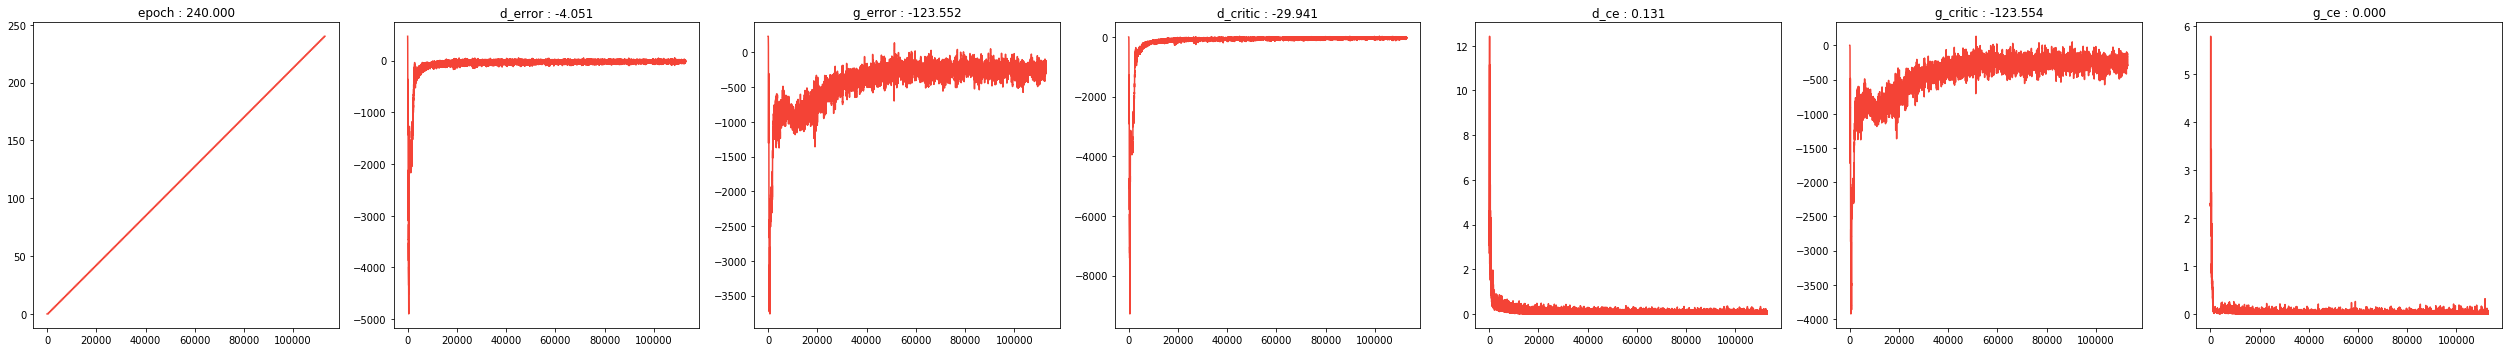

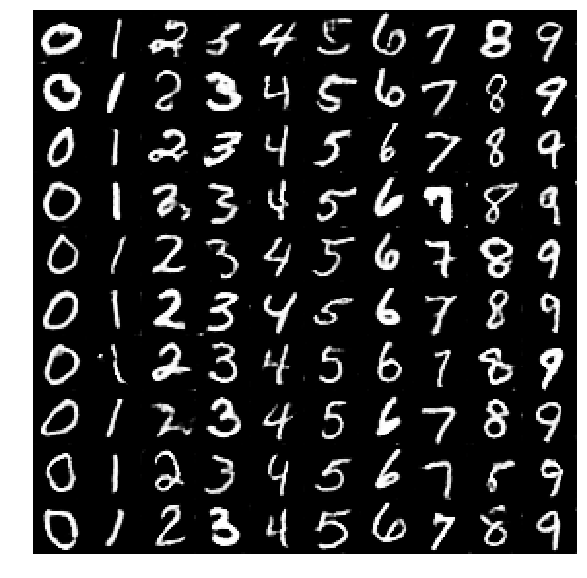

In [ ]:
gen_steps = 1
gen_train_freq = 5
try:
    while True:
        for n_batch, (real_batch,label_batch) in enumerate(data_loader):
            #one hot labels
            label_batch = oneHot(label_batch[:,None],10).float().to(device)[:,:,None,None]
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = real_batch.to(device) #images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)[:,:,None,None]
            random_labels = torch.randint(10, size=(N,1) ).long()
            random_labels = oneHot(random_labels,10).float().to(device)[:,:,None,None]
            with torch.no_grad():
                fake_data = generator(noise_tensor, random_labels)# torch.cat([noise_tensor,random_labels],1)).detach()
            # Train D
            d_error ,d_critic,d_ce= train_discriminator(d_optimizer, real_data,label_batch, fake_data,random_labels)

            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # 2. Train Generator
                    # Generate fake data
                    noise_tensor = noise(N,noise_dim)[:,:,None,None]
                    random_labels = torch.randint(10, size=(N,1) ).long()
                    random_labels = oneHot(random_labels,10).float().to(device)[:,:,None,None]
                    fake_data = generator(noise_tensor,random_labels) #torch.cat([noise_tensor,random_labels],1))
                    # Train G
                    g_error,g_critic,g_ce = train_generator(g_optimizer, fake_data,random_labels)
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error.item(),"g_critic":g_critic.item(),"d_critic":d_critic.item(), "g_ce":g_ce.item(),"d_ce":d_ce.item()} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            # Display Progress every few batches
            if global_step % 50 == 0:
                labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
                labels = oneHot(labels[:,None],10).float().to(device)[:,:,None,None]
                test_images = generator(test_noise, labels).squeeze() 
                test_images = test_images.data
                L = 28
                canvas = np.zeros((L*m,L*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
                        q+=1
                dis.display(scale=False)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                if False:#epoch % 50 == 0:
                    plt.savefig("c-DC-GAN/c-DC-GAN-MNIST-Epoch="+str(epoch)+".png")
                plt.show()
        epoch+=1
except:
    labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
    labels = oneHot(labels[:,None],10).float().to(device)[:,:,None,None]
    test_images = generator(test_noise, labels).squeeze() 
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
            q+=1
    dis.display(scale=False)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("AC-DC-WGAN-GP-MNIST.png")
    plt.show()

## Conclusion

While the cGAN approach was difficult to merge in DC-WGAN-GP framework, the AC-GAN approach performed particularly well.